In [ ]:
!pip install shap

In [ ]:
! pip install optuna

In [14]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from math import sqrt
import os
import missingno as msno
import calendar
import datetime
from math import sqrt

#시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

#preprocessing
from sklearn.metrics import mean_squared_error, mean_squared_log_error, make_scorer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

#models
from sklearn.ensemble import RandomForestRegressor

#최적화
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

# #Xai
# from functools import partial 
# import shap

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train = pd.read_csv(train_path)
cat_col = ["season", "Year","weather", "Day of week","Month","Day_info"] #Hour
for col in cat_col:
    train[col] = train[col].astype("category")
#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year", "Hour",target_col] #"sin_hour", "cos_hour"
train.drop(drop_cols, axis=1)

cat_col = ["season", "weather", "Day of week", "Month", "Day_info"] #"Hour"
train = pd.get_dummies(train, columns=cat_col)
st.write(train.head(3))

In [16]:
test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

test.drop("Unnamed: 0", axis=1, inplace=True)
train.drop("Unnamed: 0", axis=1, inplace=True)

#cat features
cat_col = ["season", "Year","weather", "Day of week","Month","Day_info"] #Hour
for col in cat_col:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

#train, valid split
days = list(range(1, 15))
train_d = train.loc[train['Day'].isin(days)]
test_d = train.loc[~(train['Day'].isin(days))]

#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year", "Hour",target_col] #"sin_hour", "cos_hour"

x_train, y_train = train_d.drop(drop_cols, axis=1), train_d[target_col]
x_test, y_test = test_d.drop(drop_cols, axis=1), test_d[target_col]

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

x_train.head()

,season,weather,temp,humidity,windspeed,Day of week,Month,Day_info,sin_hour,cos_hour
0,1,Good,9.84,81,0.0,Saturday,1,Weekend,0.000000,1.000000
1,1,Good,9.02,80,0.0,Saturday,1,Weekend,0.258819,0.965926
2,1,Good,9.02,80,0.0,Saturday,1,Weekend,0.500000,0.866025
3,1,Good,9.84,75,0.0,Saturday,1,Weekend,0.707107,0.707107
4,1,Good,9.84,75,0.0,Saturday,1,Weekend,0.866025,0.500000


In [17]:
cat_col = ["season", "weather", "Day of week", "Month", "Day_info"] #"Hour"

test = pd.get_dummies(test, columns=cat_col)
train = pd.get_dummies(train, columns=cat_col)

x_test = pd.get_dummies(x_test, columns=cat_col)
x_train = pd.get_dummies(x_train, columns=cat_col)

x_train.head()

,temp,humidity,windspeed,sin_hour,cos_hour,season_1,season_2,season_3,season_4,weather_Good,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Day_info_Weekend,Day_info_weekday&holiday,Day_info_working day
0,9.84,81,0.0,0.000000,1.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,9.02,80,0.0,0.258819,0.965926,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,9.02,80,0.0,0.500000,0.866025,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,9.84,75,0.0,0.707107,0.707107,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,9.84,75,0.0,0.866025,0.500000,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [18]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.expm1(y_true)
        y_pred = np.expm1(y_pred)
        
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

In [19]:
def objective(trial: Trial) -> float:
    params_rf = {
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 100, 700),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2", None])
    }

    n_splits=5
    random_state=42
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = []

    #local_train, local_valid를 5번 만들어서 수행
    for train_index, valid_index in kf.split(X=x_train, y=y_train):
        X_train, Y_train = x_train.iloc[train_index], np.log1p(y_train[train_index])
        X_valid, Y_valid = x_train.iloc[valid_index], np.log1p(y_train[valid_index])

        model = RandomForestRegressor(**params_rf)
        model.fit(X_train, Y_train )

        rf_pred = model.predict(X_valid)
        scores.append(rmsle(Y_valid, rf_pred))

    return np.mean(scores)

In [20]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="Randomforest",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=50)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-03-22 23:06:48,464] A new study created in memory with name: Randomforest
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this 

Best Score: 0.381348984317962
Best trial: {'n_estimators': 568, 'max_features': None}


In [21]:
# 시각화
optuna.visualization.plot_optimization_history(study)

In [22]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [23]:
study.best_trial.params

{'n_estimators': 568, 'max_features': None}

In [24]:
op_tuned = RandomForestRegressor(**study.best_trial.params)
# op_tuned = RandomForestRegressor(**{'n_estimators': 435, 'max_features': None})
op_tuned.fit(x_train, np.log1p(y_train))

RandomForestRegressor(max_features=None, n_estimators=568)

In [26]:
y_pred = op_tuned.predict(x_test)
x_test["y_pred"] = np.expm1(y_pred)
test_rm = np.round(rmsle(y_test, x_test["y_pred"], False), 3)
print("RMSLE", test_rm)

RMSLE 0.42


In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=x_test["y_pred"], mode="markers", name="test_predict"))
fig.add_trace(go.Scatter(x=y_test, y=y_test, mode="lines", name="test_real"))
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
)
fig.update_layout(title=dict({"text": f"RMSLE: {test_rm}"}))
fig.update_layout(xaxis=dict({"title": "Real"}))
fig.update_layout(yaxis=dict({"title": "Predict"}))
fig.show()

### 양식은 linear로


In [31]:
test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

test.drop("Unnamed: 0", axis=1, inplace=True)
train.drop("Unnamed: 0", axis=1, inplace=True)

#cat features
cat_col = ["season", "Year","weather", "Day of week","Month","Day_info"] #Hour
for col in cat_col:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year", "Hour",target_col] #"sin_hour", "cos_hour"

X_train, Y_train = train.drop(drop_cols, axis=1), train[target_col]
X_test = test.drop(["datetime", "workingday", "holiday", "Day", "Year", "Hour"], axis=1)

X_train.head()

,season,weather,temp,humidity,windspeed,Day of week,Month,Day_info,sin_hour,cos_hour
0,1,Good,9.84,81,0.0,Saturday,1,Weekend,0.000000,1.000000
1,1,Good,9.02,80,0.0,Saturday,1,Weekend,0.258819,0.965926
2,1,Good,9.02,80,0.0,Saturday,1,Weekend,0.500000,0.866025
3,1,Good,9.84,75,0.0,Saturday,1,Weekend,0.707107,0.707107
4,1,Good,9.84,75,0.0,Saturday,1,Weekend,0.866025,0.500000


In [32]:
cat_col = ["season", "weather", "Day of week", "Month", "Day_info"] #"Hour"

X_test = pd.get_dummies(X_test, columns=cat_col)
X_train = pd.get_dummies(X_train, columns=cat_col)

x_train.head()

,temp,humidity,windspeed,sin_hour,cos_hour,season_1,season_2,season_3,season_4,weather_Good,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Day_info_Weekend,Day_info_weekday&holiday,Day_info_working day
0,9.84,81,0.0,0.000000,1.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,9.02,80,0.0,0.258819,0.965926,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,9.02,80,0.0,0.500000,0.866025,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,9.84,75,0.0,0.707107,0.707107,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,9.84,75,0.0,0.866025,0.500000,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [33]:
op_tuned_final = RandomForestRegressor(**study.best_trial.params)
op_tuned_final.fit(X_train, np.log1p(Y_train))

sub_pred = op_tuned_final.predict(X_test)
sub_pred = np.expm1(sub_pred)

test["count"] = sub_pred
submission = test[["datetime", "count"]]
submission.head()

,datetime,count
0,2011-01-20 00:00:00,12.806864
1,2011-01-20 01:00:00,4.108373
2,2011-01-20 02:00:00,3.492564
3,2011-01-20 03:00:00,3.336033
4,2011-01-20 04:00:00,3.177486


In [34]:
# 0.442
submission.to_csv("RF_cos_Hour.csv", index=False)

In [37]:
op_tuned_final.predict

<bound method ForestRegressor.predict of RandomForestRegressor(max_features=None, n_estimators=568)>

### shapley value

In [38]:
import shap

# Fits the explainer
explainer = shap.Explainer(op_tuned_final.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 6494it [2:59:24,  1.66s/it]


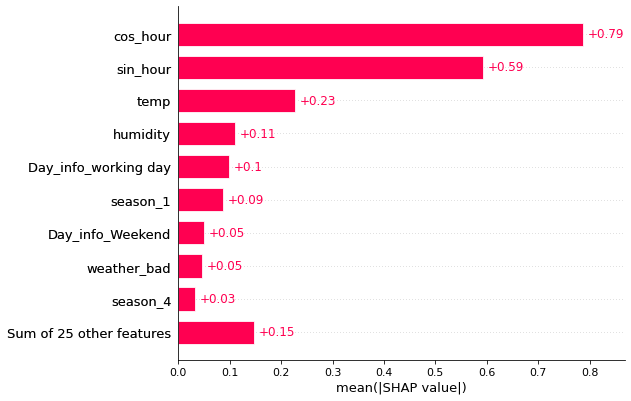

In [39]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


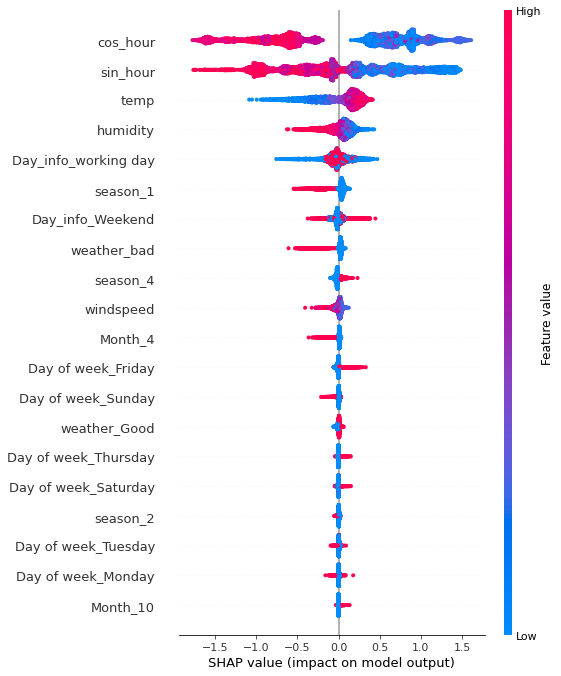

In [40]:
shap.summary_plot(shap_values)

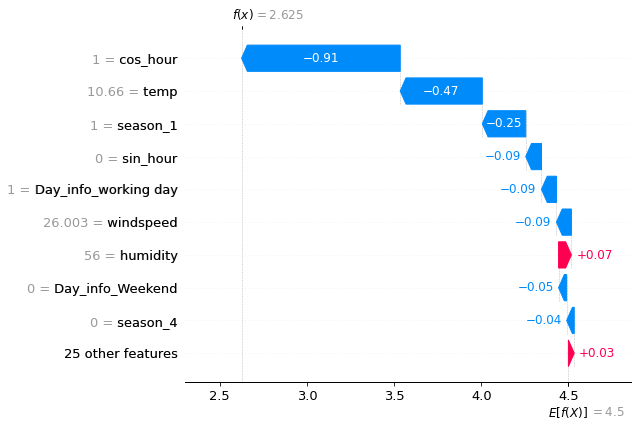

In [41]:
shap.plots.waterfall(shap_values[0])

In [49]:
shap.initjs()
shap.plots.force(shap_values[0])

In [42]:
test.head(1)

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,Day of week,Year,Month,Day,Hour,Day_info,sin_hour,cos_hour,count
0,2011-01-20 00:00:00,1,0,1,Good,10.66,56,26.0027,Thursday,2011,1,20,0,working day,0.0,1.0,12.806864


In [43]:
np.expm1(2.625)

12.804574186067095